In [1]:
import io
import os
import xml.etree.ElementTree as et 
import xmltodict
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\MiKTeX 2.9\\miktex\\bin\\x64\\'
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\gs\\gs9.52\\bin\\'
matplotlib.rcParams['text.usetex'] = True

# Get data

COVID-19 Open Research Dataset (CORD-19). 2020. Version 2020-05-01. Retrieved from https://pages.semanticscholar.org/coronavirus-research. Accessed 2020-05-01. doi:10.5281/zenodo.3715505

The query used by the authors is as follows:

    "COVID-19"[All Fields] OR ("coronavirus"[MeSH Terms] OR "coronavirus"[All Fields]) OR "Corona virus"[All Fields] OR "2019-nCoV"[All Fields] OR "SARS-CoV"[All Fields] OR "MERS-CoV"[All Fields] OR "Severe Acute Respiratory Syndrome"[All Fields] OR "Middle East Respiratory Syndrome"[All Fields]

In [2]:
cord19 = pd.read_csv("https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/latest/metadata.csv", low_memory=False) # last retrieved: 2020-05-01
cord19.shape

(59887, 19)

In [3]:
cord19.rename(columns = {'cord_uid'      :'id', 
                          'publish_time' :'published', 
                          'abstract'     :'summary', 
                          'authors'      :'author',  
                          'source_x'     :'source'}, inplace=True)


# Keep only articles with title and summary, published in 2019 or 2020
cord19['published'] = pd.to_datetime(cord19['published'])
cord19.dropna(subset=['title', 'summary'], how='all', inplace=True)
cord19 = cord19[cord19.published.dt.year.isin([2019,2020])].copy()

## Extract AI papers

In [4]:
cord19['paper_type'] = 'Not AI'
cord19['paper_type'] = np.where(cord19['title'  ].astype(str).str.lower().str.contains("(machine learning|artificial intelligence|deep learning|neural network)"), 
                                'AI', 
                                cord19['paper_type'])
cord19['paper_type'] = np.where(cord19['summary'].astype(str).str.lower().str.contains("(machine learning|artificial intelligence|deep learning|neural network)"), 
                                'AI', 
                                cord19['paper_type'])

C:\Users\Katherine\.conda\envs\py36\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [5]:
# Save all papers
cord19[cord19.paper_type=="AI"].to_csv("list_of_papers.csv", encoding='utf-8-sig')
cord19[cord19.paper_type=="AI"].shape

(274, 20)

# Analyze

## Total counts

In [6]:
# How many AI papers in our time window?
cord19[cord19.paper_type=="AI"].set_index("published").loc['2020-01-01':'2020-04-24'].count()['title']

216

In [7]:
# How many total COVID papers in our time window?
cord19.set_index("published").loc['2020-01-01':'2020-04-24'].count()['title']

8787

In [8]:
cord19.source.value_counts()

Elsevier    4943
PMC         4654
medrxiv     2007
WHO          907
biorxiv      835
arxiv        706
CZI          100
Name: source, dtype: int64

## Plot

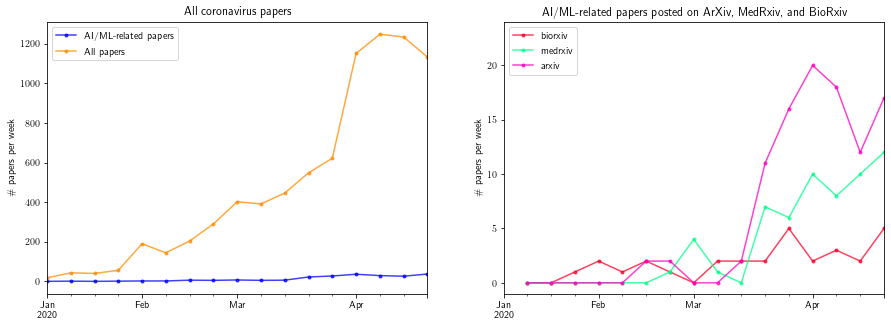

In [9]:
fig, ax = plt.subplots(1,2, figsize=[15,5])

# Note: we start from 2 January because it looks like articles with missing date get assigned to Jan 1
plot_df = cord19.set_index('published').loc['2020-01-02':'2020-04-24'].reset_index()

###############################
# Plot all papers (left panel)
###############################

plot_df1 = plot_df.groupby([plot_df.published.dt.to_period('W'), 
                            plot_df.paper_type]).count()['id'].unstack(level=['paper_type']).fillna(0)

plot_df1['All papers'] = plot_df1['AI'] + plot_df1['Not AI']


plot_df1[['AI', 'All papers']].plot(ax=ax[0],  legend=True,  alpha=0.75, color=['blue', 'darkorange'], marker=".")
ax[0].set_xlabel("")
ax[0].set_ylabel("$\#$ papers per week")
ax[0].set_title("All coronavirus papers") #CORD-19 papers + ArXiv papers mentioning covid/coronavirus/sars-cov-2")
ax[0].legend(["AI/ML-related papers", "All papers"])

##################################
# Plot ML/AI papers (right panel)
##################################

plot_df = plot_df[plot_df.source.isin(['arxiv', 'medrxiv', 'biorxiv'])]

plot_df2 = plot_df.groupby([plot_df.published.dt.to_period('W'), 
                            plot_df.source, 
                            plot_df.paper_type]).count()['id'].unstack(level=['paper_type']).fillna(0)

plot_df2['All papers'] = plot_df2['AI'] + plot_df2['Not AI']
plot_df2 = plot_df2.unstack(level='source').fillna(0)

plot_df2['AI'][['biorxiv', 'medrxiv', 'arxiv']].plot(alpha=0.75, ax=ax[1], cmap='gist_rainbow', marker=".")

ax[1].set_xlabel("")
ax[1].set_ylabel("$\#$ papers per week")
ax[1].set_title("AI/ML-related papers posted on ArXiv, MedRxiv, and BioRxiv") 
ax[1].legend(["BioRxiv", 'MedRxiv', 'ArXiv'])


##################################
# Polish and save plot
##################################

ax[0].set_xlim('2020-01-02', '2020-04-24')
ax[1].set_xlim('2020-01-02', '2020-04-24')
ax[1].set_ylim(-1, 24)
ax[1].legend(loc='upper left')

plt.savefig("automated_lit_review.pdf", dpi=100, bbox_inches="tight")
plt.savefig("automated_lit_review.png", dpi=100, bbox_inches="tight")

In [10]:
plot_df1['All papers'].cumsum()

published
2019-12-30/2020-01-05      18.0
2020-01-06/2020-01-12      61.0
2020-01-13/2020-01-19     101.0
2020-01-20/2020-01-26     157.0
2020-01-27/2020-02-02     347.0
2020-02-03/2020-02-09     491.0
2020-02-10/2020-02-16     695.0
2020-02-17/2020-02-23     985.0
2020-02-24/2020-03-01    1387.0
2020-03-02/2020-03-08    1778.0
2020-03-09/2020-03-15    2224.0
2020-03-16/2020-03-22    2772.0
2020-03-23/2020-03-29    3394.0
2020-03-30/2020-04-05    4545.0
2020-04-06/2020-04-12    5793.0
2020-04-13/2020-04-19    7027.0
2020-04-20/2020-04-26    8160.0
Freq: W-SUN, Name: All papers, dtype: float64

In [11]:
plot_df1['AI'].cumsum()

published
2019-12-30/2020-01-05      0.0
2020-01-06/2020-01-12      1.0
2020-01-13/2020-01-19      1.0
2020-01-20/2020-01-26      2.0
2020-01-27/2020-02-02      4.0
2020-02-03/2020-02-09      6.0
2020-02-10/2020-02-16     12.0
2020-02-17/2020-02-23     17.0
2020-02-24/2020-03-01     24.0
2020-03-02/2020-03-08     29.0
2020-03-09/2020-03-15     35.0
2020-03-16/2020-03-22     57.0
2020-03-23/2020-03-29     84.0
2020-03-30/2020-04-05    120.0
2020-04-06/2020-04-12    149.0
2020-04-13/2020-04-19    175.0
2020-04-20/2020-04-26    212.0
Freq: W-SUN, Name: AI, dtype: float64